# Sen12MS preprocessing

This notebook is meant to perform the data-preprocessing operation described in Section 3.1.  
The main objective is to extract the land-cover content out of the MODIS-IGBP labels originally provided by the authors, converting them into the DFC2020 scheme.  
The notebook is a updated version of the [Sen12MSOverview](https://github.com/schmitt-muc/SEN12MS/blob/master/utils/Sen12MSOverview.ipynb).

Author: Marc Rußwurm  
Additional modifications: Edoardo Daniele Cannas (edoardodaniele.cannas@polimi.it)

## Libraries import

In [1]:
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family': 'Trebuchet MS'})
import geopandas as gpd
import contextily as ctx
import rasterio
import numpy as np
from pyproj import Proj, transform
from typing import List, Tuple
import geopy
from geopy.geocoders import Nominatim, Photon

classes = [
    "Evergreen Needleleaf Forests",
    "Evergreen Broadleaf Forests",
    "Deciduous Needleleaf Forests",
    "Deciduous Broadleaf Forests",
    "Mixed Forests",
    "Closed (Dense) Shrublands",
    "Open (Sparse) Shrublands",
    "Woody Savannas",
    "Savannas",
    "Grasslands",
    "Permanent Wetlands",
    "Croplands",
    "Urban and Built-Up Lands",
    "Cropland/Natural Vegetation Mosaics",
    "Permanent Snow and Ice",
    "Barren",
    "Water Bodies"
]  # IGBP classes scheme

colors_simple = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']  # color scheme for simpli

## Helpers functions

In [27]:
def autolabel(ax, rects, label_format='{:.3f}'):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(label_format).format(height),
                         xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
            plt.xticks(fontsize=14)


def group_bar_plot(ax, data, xticks_labels=None, orientation=0, colors=None, total_width=0.8, single_width=1, 
                   legend=True, reclabel=False, label_format='{:.3f}'):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }
    
    xticks_labels: tuple
        A tuple containing the strings for the labels on the xticks.
        
        Example:
        xticks_labels = ('exp1', 'exp2', 'exp3')
    
    orientation: String
        A string defining the orientation of the labels on the xticks
        
        Example:
        orientation = 'vertical'

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            if autolabel:
                autolabel(ax, bar, label_format)
        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
#         autolabel(bar)

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())
    
    # Draw labels centered on the bar groups if needed
    if xticks_labels is not None:
        start_pos = (-n_bars/2)*bar_width+total_width/4+bar_width
        centered_ticks = [i+start_pos for i in range(xticks_labels.__len__())]
        ax.set_xticks(centered_ticks)
    #     ax.set_xticks([i+xticks_pos[0]+total_width/4+bar_width/2 for i in range(xticks_pos.__len__())])
        ax.set_xticklabels(xticks_labels)
    
    # Set labels' orientation if needed
    if orientation is not None:
        ax.tick_params(labelrotation=orientation)
    
    # Autolabel the bars
#     autolabel(bars)

def load_raster(path: str, sensor: str) -> np.array:
    """
    Simple function to load and normalize raster data with rasterio
    :param path: str, path to the .tif file
    :param sensor: str, either s1 or s2 sentinel
    :return np.array, the array of raster data
    """
    with rasterio.open(path, 'r') as src:
        rdata = src.read()
        
    if sensor == 's1':
        rdata = rdata.astype(np.float32)
        rdata = np.nan_to_num(rdata)
        rdata = np.clip(rdata, -25, 0)
        rdata /= 25
        rdata += 1
        rdata = rdata.astype(np.float32)
    elif sensor == 's2':
        rdata = rdata.astype(np.float32)
        rdata = np.clip(rdata, 0, 10000)
        rdata /= 10000
        rdata = rdata.astype(np.float32)
    
    return rdata



def st_scaler(img: np.array) -> np.array:
    """
    Standard scaler implementation
    
    :param img: np.array, the tensor
    """
    img = img.astype(np.float32)
    img = (img-img.min())/(img.max()-img.min())
    return img


# Functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band: np.array) -> np.array:
    """
    Convert to linear units
    
    :param band: np.array, the dB SAR tile to convert
    """
    return np.power(10, np.array(band)/10)


def linear_to_decibel(band):
    """
    Convert to dB
    
    :param band: np.array, the SAR tile to convert into dB
    """
    return 10*np.log10(band)


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

## Execution parameters
Place here all the variables neeeded for executing the rest of the notebook.

In [3]:
root = "/nas/public/dataset/SEN12MS"  # PLACE HERE THE ABSOLUTE PATH WHERE THE SEN12MS DATASET IS LOCATED IN YOUR MACHINE

## Iterate through files
We are going to iterate through each raster contained in the Sen12MS and extract the following information:
1. `seed`: the seed used for collecting the triplet of raster data;
2. `season`: the season when the raster data has been collected;
3. `sensor`: the sensor relative to the specific tile (S1, S2 or MODIS);
4. `region`: the region where the raster data has been collected;
5. `tile`: the filename of the tile.

We are going to save this info in the `../data` folder as CSV file.

In [4]:
if os.path.exists(os.path.join('../data','tiles_info_df.csv')):
    tiles = pd.read_csv(os.path.join('../data','tiles_info_df.csv'), index_col=0)
else:
    tiles = pd.DataFrame(glob.glob(os.path.join(root,'*','*','*.tif')), columns=["path"])
    split = tiles["path"].apply(lambda path: os.path.basename(path).split('_'))
    split = pd.DataFrame.from_records(split, columns=["seed","season","sensor","region","tile"])
    tiles = tiles.join(split)
    tiles.to_csv(os.path.join('../data',"tiles_info_df.csv"))

### Samples inspection
Let's look at some triples just for fun.

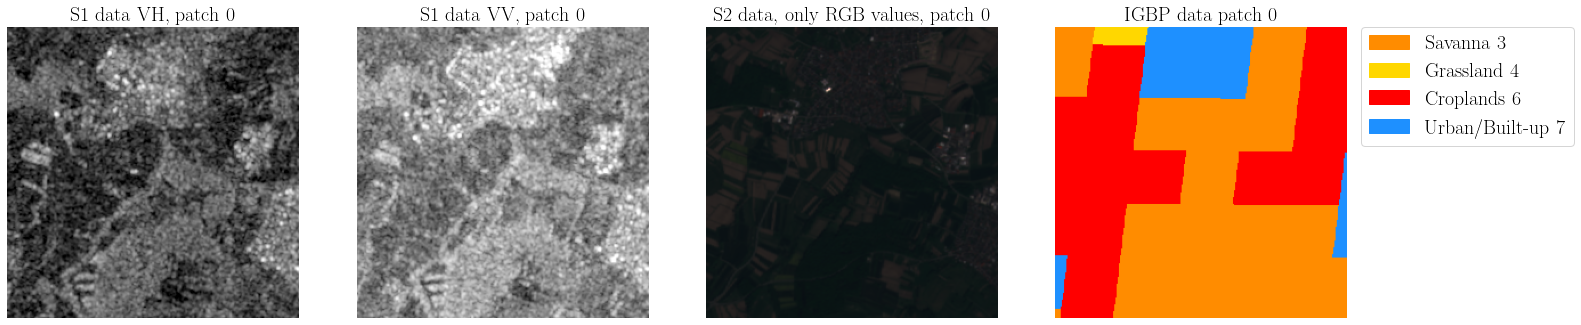

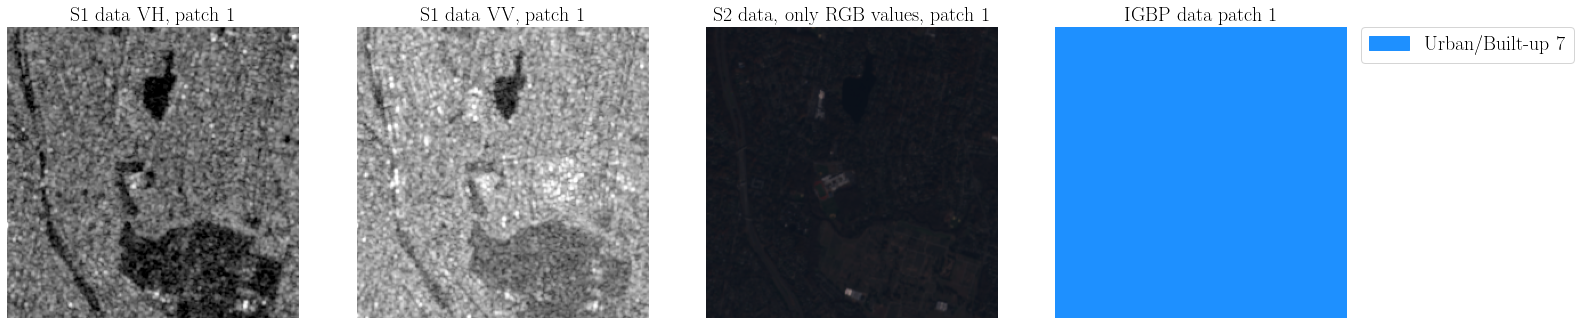

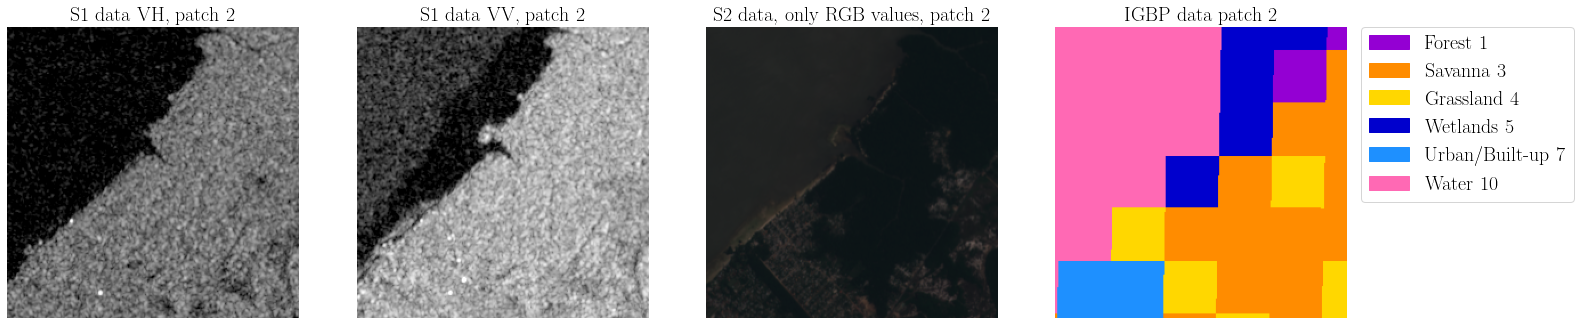

In [26]:
### Select a region in a specific ROI and season
r1_df = tiles.loc[(tiles['region']==120) & (tiles['tile']=='p101.tif')]
### Select 5 random patches
patches_lab = ['spring','fall','summer' ]

# Recreate the classes vector
classes_mapping = {i+1:classes[i] for i in range(len(classes))}
colors_simple = ['darkviolet','green','darkorange','gold','mediumblue','red','dodgerblue','cyan','gray','hotpink']

# define color map 
color_map = {1: np.array([148, 0, 211]), # darkviolet
             2: np.array([0, 128, 0]), # green
             3: np.array([255, 140, 0]), # darkorange
             4: np.array([255, 215, 0]), # gold
             5: np.array([0, 0, 205]), # mediumblue
             6: np.array([255, 0, 0]), # red
             7: np.array([30, 144, 255]), # dodgerblue
             8: np.array([0, 255, 255]), # cyan
             9: np.array([128, 128, 128]), # gray
             10: np.array([255, 105, 180]), # hotpink
            }


# Cycle over the patches
for patch in range(len(patches_lab)):
    
    # Load the triplet
    triplet = r1_df.loc[r1_df['season']==patches_lab[patch]]
    
    # Plot the data
    fig, axs = plt.subplots(1, 4, figsize=(24, 18))  # layout: S1, S2 (RGB), label LCCS
    axs[0].imshow(load_raster(triplet.loc[triplet['sensor']=='s1']['path'].item(), 's1')[1], cmap='gray',vmin=0, vmax=1)  # plot only a polarization for SAR
    axs[0].set_title('S1 data VH, patch {}'.format(patch), fontsize=20)
    axs[0].axis('off')
    
    axs[1].imshow(load_raster(triplet.loc[triplet['sensor']=='s1']['path'].item(), 's1')[0], cmap='gray',vmin=0, vmax=1)  # plot only a polarization for SAR
    axs[1].set_title('S1 data VV, patch {}'.format(patch), fontsize=20)
    axs[1].axis('off')
    
    
    sen_2=np.zeros((256,256,3))
    sen_2[:,:,0:1]=(np.moveaxis(load_raster(triplet.loc[triplet['sensor']=='s2']['path'].item(), 's2')[3:4], 0, 2))
    sen_2[:,:,1:2]=(np.moveaxis(load_raster(triplet.loc[triplet['sensor']=='s2']['path'].item(), 's2')[2:3], 0, 2))
    sen_2[:,:,2:3]=(np.moveaxis(load_raster(triplet.loc[triplet['sensor']=='s2']['path'].item(), 's2')[1:2], 0, 2))
    axs[2].imshow((sen_2))
    axs[2].set_title('S2 data, only RGB values, patch {}'.format(patch), fontsize=20)
    axs[2].axis('off')
    
    
  
    # Load label
    label = load_raster(triplet.loc[triplet['sensor']=='lc']['path'].item(), None)[0]
    values = np.unique(label.ravel())
    # Substitute values with DFC_2020 scheme
    for value in values:
        label[label==value] = simple_classes_idx[value-1]
        
    # make a 3d numpy array that has a color channel dimension   
    data_3d = np.ndarray(shape=(label.shape[0], label.shape[1], 3), dtype=int)
    for i in range(0, label.shape[0]):
        for j in range(0, label.shape[1]):
            data_3d[i][j] = color_map[label[i][j]]
            
            
    img = axs[3].imshow(data_3d)
    axs[3].set_title('IGBP data patch {}'.format(patch), fontsize=20)
    axs[3].axis('off')
    
    # Add the colors for the labels of the IGBP
    values = np.unique(label.ravel())  # recompute unique values
    # create a patch (proxy artist) for every color 
    patches_legend = [ mpatches.Patch(color=colors_simple[val-1], label="{c} {l}".format(c=simple_classes[values[i]-1], l=values[i]) ) for i,val in enumerate(values) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=20)
    plt.show()

## Read label tifs and add land-cover class information
We are going to cycle over the different IGBP land-cover maps, and compute the histograms for the different classes.  
We are going to add a column for each land-cover class in the scheme indicating the amount of pixels inside the tile for that specific class.

In [28]:
from multiprocessing import Pool
import tqdm

# Load TIFF labels
# ATTENTION: images are a 4 channel tensor, with channel 0 = IGBP, channels 1-3 LCSS1-3(LCCS Land Cover, LCCS Land Use, and LCCS Surface Hydrology layers)
lc = tiles.loc[tiles["sensor"] == "lc"]
  
# Normed histogram computation
if os.path.exists(os.path.join('../data',"histogram_orig_fixed.csv")):
    histogram = pd.read_csv(os.path.join('../data',"histogram_orig_fixed.csv"), index_col=0)
else:
    def get_histogram(path):
        with rasterio.open(path, 'r') as src:
            arr = src.read(1)
        counts = np.histogram(arr,bins=len(classes), range=(1, len(classes)))[0]
        return dict(zip(classes,counts))

    histograms = lc["path"].apply(get_histogram)
    histogram = pd.DataFrame(histograms.to_list(), index=histograms.index)
    histogram = lc.join(histogram)
    histogram.to_csv(os.path.join('../data',"histogram_orig_fixed.csv"))
    
histogram

,path,seed,season,sensor,region,tile,Evergreen Needleleaf Forests,Evergreen Broadleaf Forests,Deciduous Needleleaf Forests,Deciduous Broadleaf Forests,...,Woody Savannas,Savannas,Grasslands,Permanent Wetlands,Croplands,Urban and Built-Up Lands,Cropland/Natural Vegetation Mosaics,Permanent Snow and Ice,Barren,Water Bodies
0,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p100.tif,0,0,0,0,...,14530,24392,26614,0,0,0,0,0,0,0
1,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p102.tif,0,0,0,0,...,29919,13892,21725,0,0,0,0,0,0,0
2,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p106.tif,0,0,0,0,...,1700,54822,9014,0,0,0,0,0,0,0
3,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p119.tif,0,0,0,0,...,51241,11229,2857,0,0,0,0,0,0,0
4,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p122.tif,0,0,0,0,...,20143,8377,37016,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450475,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p915.tif,30656,0,0,0,...,0,0,0,0,0,0,0,0,0,0
450476,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p917.tif,57970,0,0,0,...,6295,0,0,0,0,0,0,0,0,0
450477,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p950.tif,41409,0,0,0,...,4521,0,0,0,0,0,0,0,0,0
450478,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p952.tif,42084,0,0,0,...,8339,0,0,0,0,0,0,0,0,0


### Normalize them in percentage

In [14]:
histogram_norm = histogram.copy()
for igbp_class in classes:
    histogram_norm[igbp_class] = histogram[igbp_class].apply(lambda x: 100*x/256**2)
histogram_norm

,path,seed,season,sensor,region,tile,Evergreen Needleleaf Forests,Evergreen Broadleaf Forests,Deciduous Needleleaf Forests,Deciduous Broadleaf Forests,...,Woody Savannas,Savannas,Grasslands,Permanent Wetlands,Croplands,Urban and Built-Up Lands,Cropland/Natural Vegetation Mosaics,Permanent Snow and Ice,Barren,Water Bodies
0,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p100.tif,0.000000,0.0,0.0,0.0,...,22.171021,37.219238,40.609741,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p102.tif,0.000000,0.0,0.0,0.0,...,45.652771,21.197510,33.149719,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p106.tif,0.000000,0.0,0.0,0.0,...,2.593994,83.651733,13.754272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p119.tif,0.000000,0.0,0.0,0.0,...,78.187561,17.134094,4.359436,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p122.tif,0.000000,0.0,0.0,0.0,...,30.735779,12.782288,56.481934,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450475,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p915.tif,46.777344,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450476,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p917.tif,88.455200,0.0,0.0,0.0,...,9.605408,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450477,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p950.tif,63.185120,0.0,0.0,0.0,...,6.898499,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450478,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p952.tif,64.215088,0.0,0.0,0.0,...,12.724304,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Watch out, we need to adjust the label scheme according to the actual population of the dataset
We'll rely on the DFC2020 scheme, which is more accurate.  
The original MODIS land-cover maps provide land-cover classes following the IGBP scheme.  
This scheme comprehends **17 different classes**, of which however the actual coverage accuracy and definition have been discussed.  
Therefore, in the following we will refer to a **simplified 10 classes labeling scheme** which eliminates some of the classes and groups together semantically similar categories (e.g., Evergreen Leaf Forest and Evergreen Broad Forest are grouped into a single Forest class).  
The scheme followed is the one actually employed in the [IEEE Geoscience and Remote Sensing Society Data Fusion Contest 2020](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest), dedicated to the development of a data-driven solution for land-cover mapping and that it used the SEN12MS as official dataset.

In [15]:
# Create the basis for the simple class histogram DataFrame
histogram_simple = histogram_norm[['path', 'seed', 'season', 'sensor', 'region', 'tile']].copy()
simple_classes = ["Forest", "Shrubland", "Savanna", "Grassland", "Wetlands",
                  "Croplands", "Urban/Built-up", "Snow/Ice", "Barren", "Water"]

# Create dictionary for mapping in the simple scheme
simple_classes_mapping = {simple_classes[i]:i+1 for i in range(len(simple_classes))}

# Create the mapping from IGBP to the simple label scheme
simple_classes_idx = [
    1,
    1,
    1,
    1,
    1,
    2,
    2,
    3,  # --> will be masked if no_savanna == True
    3,  # --> will be masked if no_savanna == True
    4,
    5,
    6,  # 12 --> 6
    7,  # 13 --> 7
    6,  # 14 --> 6
    8,
    9,
    10
    ]
igbp_to_simple_classes_mapping = {classes[i]:simple_classes_idx[i] for i in range(len(classes))}

# Update the histogram DataFrame
for simple_class in simple_classes:
    # Select the corresponding idx in the simple scheme
    simple_idx = simple_classes_mapping[simple_class] 
    # Select the correct IGBP classes
    igbp_sel_classes = []
    for igbp_class, simple_class_idx in igbp_to_simple_classes_mapping.items():
        if simple_class_idx == simple_idx:
            igbp_sel_classes.append(igbp_class)
    # Sum the coverage of the "grouped" classes into the relative simple one
    histogram_simple[simple_class] = histogram_norm[igbp_sel_classes].sum(axis=1)

histogram_simple

,path,seed,season,sensor,region,tile,Forest,Shrubland,Savanna,Grassland,Wetlands,Croplands,Urban/Built-up,Snow/Ice,Barren,Water
0,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p100.tif,0.000000,0.0,59.390259,40.609741,0.0,0.0,0.0,0.0,0.0,0.0
1,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p102.tif,0.000000,0.0,66.850281,33.149719,0.0,0.0,0.0,0.0,0.0,0.0
2,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p106.tif,0.000000,0.0,86.245728,13.754272,0.0,0.0,0.0,0.0,0.0,0.0
3,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p119.tif,0.318909,0.0,95.321655,4.359436,0.0,0.0,0.0,0.0,0.0,0.0
4,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p122.tif,0.000000,0.0,43.518066,56.481934,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450475,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p915.tif,100.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
450476,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p917.tif,90.394592,0.0,9.605408,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
450477,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p950.tif,93.101501,0.0,6.898499,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
450478,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p952.tif,87.275696,0.0,12.724304,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Let's filter out the test regions

In [20]:
# Load the test regions
test_regions = pd.read_csv('../data/SEN12MS_holdOutScenes.txt', sep='\n', header=None, names=['Scene'])
test_regions['region'] = test_regions['Scene'].apply(lambda x: x.split('/')[1].split('_')[1])

# Let's filter out also the hold_out scenes (test set regions)
histogram_simple = histogram_simple.loc[~histogram_simple['region'].isin(test_regions['region'])]
histogram_simple

,path,seed,season,sensor,region,tile,Forest,Shrubland,Savanna,Grassland,Wetlands,Croplands,Urban/Built-up,Snow/Ice,Barren,Water
0,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p100.tif,0.000000,0.0,59.390259,40.609741,0.0,0.0,0.0,0.0,0.0,0.0
1,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p102.tif,0.000000,0.0,66.850281,33.149719,0.0,0.0,0.0,0.0,0.0,0.0
2,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p106.tif,0.000000,0.0,86.245728,13.754272,0.0,0.0,0.0,0.0,0.0,0.0
3,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p119.tif,0.318909,0.0,95.321655,4.359436,0.0,0.0,0.0,0.0,0.0,0.0
4,/nas/public/dataset/SEN12MS/ROIs1158_spring/lc...,ROIs1158,spring,lc,1,p122.tif,0.000000,0.0,43.518066,56.481934,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450475,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p915.tif,100.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
450476,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p917.tif,90.394592,0.0,9.605408,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
450477,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p950.tif,93.101501,0.0,6.898499,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
450478,/nas/public/dataset/SEN12MS/ROIs1868_summer/lc...,ROIs1868,summer,lc,95,p952.tif,87.275696,0.0,12.724304,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Let's save it

In [39]:
histogram_simple.to_csv(os.path.join('../data',"histogram_norm_DFC_2020_scheme.csv"))

## Let's plot some information about the dataset
Some information we are interested in:
1. Overall Distribution of the land-cover classes;
2. Number of tiles with a X% of surface covered by a specific land-cover class.

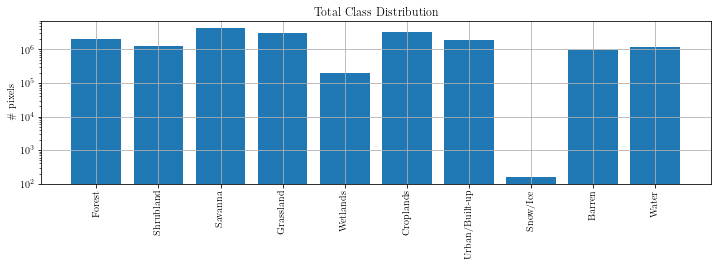

In [21]:
total = histogram_simple[simple_classes].sum(0)

fig,ax = plt.subplots(1,1,figsize=(12,3))

d = total
ax.bar(d.index, d.values)
ax.xaxis.grid()
ax.yaxis.grid()
ax.set_yscale('log')
# ax.set_yticks([1e3,1e5,1e7])
# ax.set_ylim(0,1e8)
ax.set_title(f"Total Class Distribution")
ax.set_ylabel(r"\# pixels")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
# fig.tight_layout()

### Divided by season

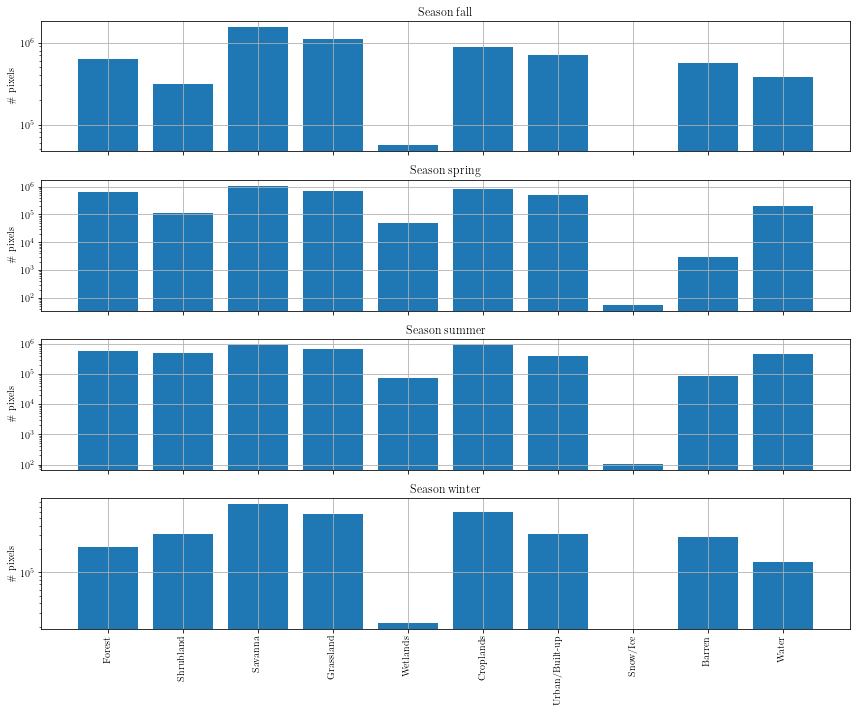

In [22]:
histogram_per_season = histogram_simple.groupby("season").sum()[simple_classes]
regions = histogram["region"].unique()

fig,axs = plt.subplots(4,1,figsize=(12,10),sharex=True)

ax = axs[0]
for ax,i in zip(axs,range(len(axs))):
    d = histogram_per_season.iloc[i]
    ax.bar(d.index, d.values)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_yscale('log')
#     ax.set_yticks([1e3,1e5,1e7])
#     ax.set_ylim(0,1e7)
    ax.set_title(f"Season {d.name}")
    ax.set_ylabel(r"\# pixels")

for tick in axs[-1].get_xticklabels():
    tick.set_rotation(90)
    
fig.tight_layout()

## Sample distribution for \% of area in the tile classes
Another perspective on the class distribution is to see how many samples we have that are covered by a certain percentage by the land-cover classes, i.e., how many samples do we have that are 90\% covered by Forest or Grassland?

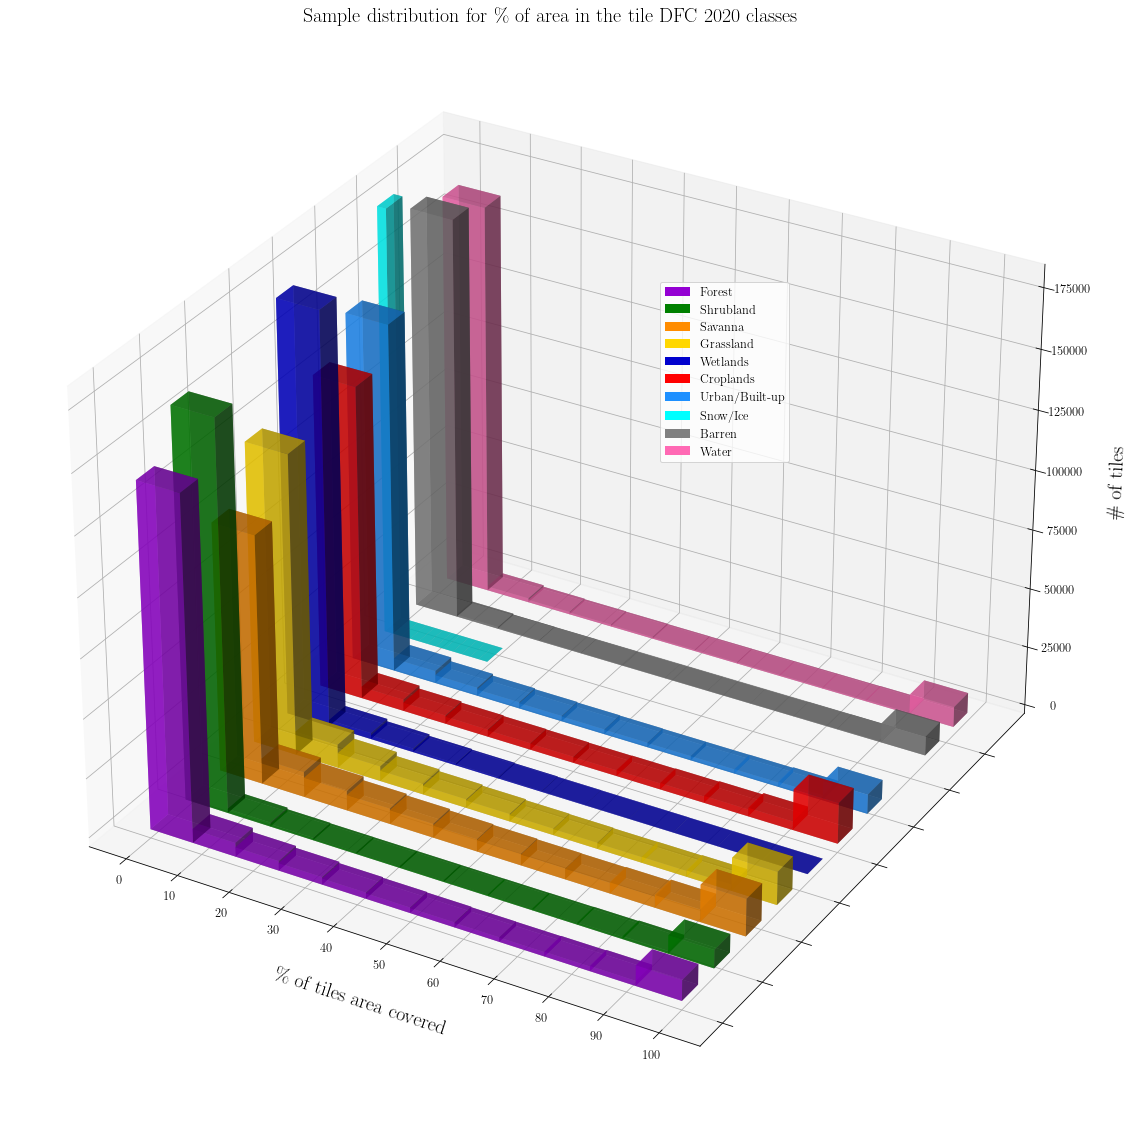

In [23]:
histogram_norm = histogram.copy()
for igbp_class in classes:
    histogram_norm[igbp_class] = histogram[igbp_class].apply(lambda x: 100*x/256**2)

# Update the histogram DataFrame
for simple_class in simple_classes:
    # Select the corresponding idx in the simple scheme
    simple_idx = simple_classes_mapping[simple_class] 
    # Select the correct IGBP classes
    igbp_sel_classes = []
    for igbp_class, simple_class_idx in igbp_to_simple_classes_mapping.items():
        if simple_class_idx == simple_idx:
            igbp_sel_classes.append(igbp_class)
    # Sum the coverage of the "grouped" classes into the relative simple one
    histogram_simple[simple_class] = histogram_norm[igbp_sel_classes].sum(axis=1)

# Create figure
fig = plt.figure(figsize=(20, 20))
# ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(111, projection='3d')
for line in ax.yaxis.get_ticklines():  # disable yticks
    line.set_visible(False)

# Create color map (go for a qualitative one)
#cmap = get_cmap(len(classes)-1, name='Paired')
#colors_simple = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
colors_simple = ['darkviolet','green','darkorange','gold','mediumblue','red','dodgerblue','cyan','gray','hotpink']


# Params for 3D plot
yspacing = 1
proxies = []

### Plot each DFC_2020 simple class distribution
for i, simple_class in enumerate(simple_classes):
    hist, bin_edges = np.histogram(histogram_simple[simple_class], bins=12)
    dx = np.diff(bin_edges)
    dy = np.ones_like(hist)
    y = i * (1 + yspacing) * np.ones_like(hist)
    z = np.zeros_like(hist)
    ax2.bar3d(bin_edges[:-1], y, z, dx, dy, hist, color=colors_simple[i],
             zsort='average', alpha=0.65)
    proxies.append(plt.Rectangle((0, 0), 1, 1, fc=colors_simple[i]))

# Add plot info
ax2.set_title(r'Sample distribution for \% of area in the tile DFC 2020 classes', fontsize=20)
ax2.legend(proxies, simple_classes, loc=(0.6, 0.6), fontsize=12.5)
ax2.set_xticks(np.arange(0, 110, 10))
ax2.set_xlabel(r'\% of tiles area covered', fontsize=20,labelpad=20)
ax2.set_zlabel(r'\# of tiles', fontsize=20, labelpad=30)
ax2.set_yticklabels([])
ax2.tick_params(axis='z', width=0.5, labelsize=12.5, pad=10)
ax2.ticklabel_format(axis='z', style='sci')
ax2.tick_params(axis='x', labelsize=12.5)

### Same plot, but in 2D

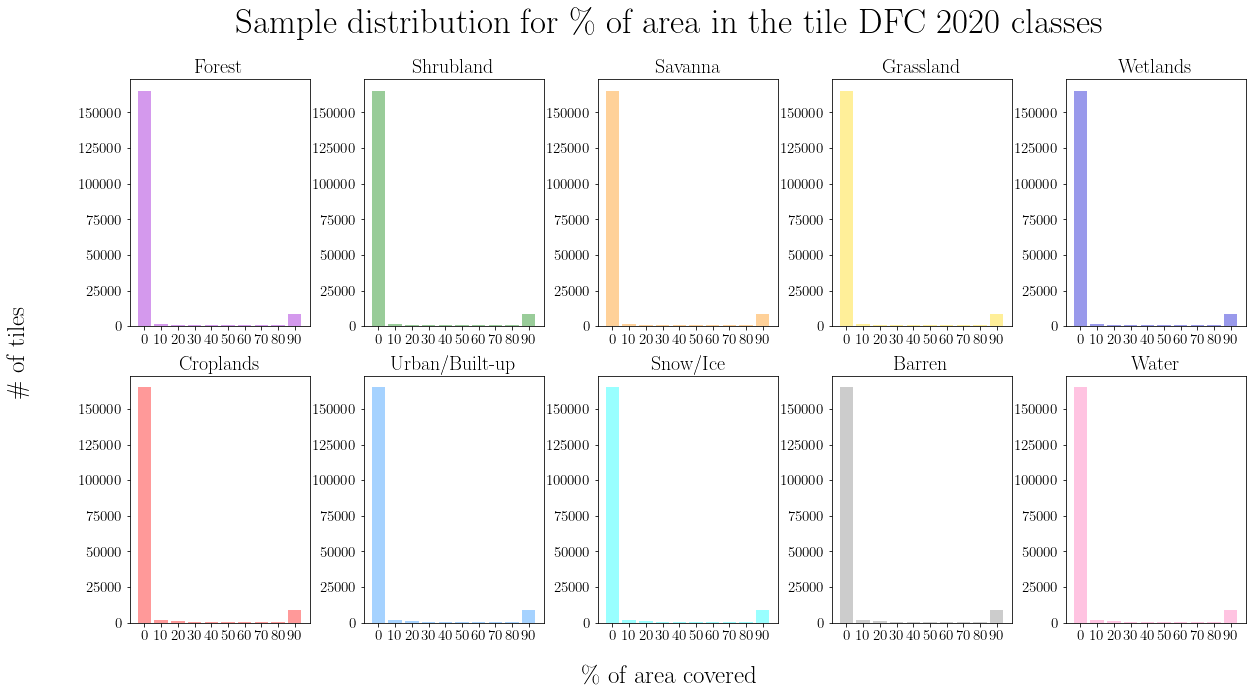

In [24]:
# Prepare figure and subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle(r'Sample distribution for \% of area in the tile DFC 2020 classes', fontsize=35)
colors_simple = ['darkviolet','green','darkorange','gold','mediumblue','red','dodgerblue','cyan','gray','hotpink']

# Bar chart with # of samples for each land-cover class
for idx, lc_class in enumerate(simple_classes):
    hist, _ = np.histogram(histogram_simple[simple_class], bins=10)
    if idx < 5:
        axs[0][idx].bar(np.arange(0, 10), hist, alpha=0.4, color=colors_simple[idx])
        axs[0][idx].set_xticks(np.arange(0, 10))
        axs[0][idx].set_xticklabels(np.arange(0, 100, 10))
        axs[0][idx].tick_params(axis='both', which='major', labelsize=15)
        axs[0][idx].set_title(f'{lc_class}', fontsize=20)
    else:
        axs[1][idx-5].bar(np.arange(0, len(hist)), hist, alpha=0.4, color=colors_simple[idx])
        axs[1][idx-5].set_xticks(np.arange(0, 10))
        axs[1][idx-5].set_xticklabels(np.arange(0, 100, 10))
        axs[1][idx-5].tick_params(axis='both', which='major', labelsize=15)
        axs[1][idx-5].set_title(f'{lc_class}', fontsize=20)

# Common x and y label for the axes
fig.text(0.5, 0.04, r'\% of area covered', ha='center', fontsize=25)
fig.text(0.04, 0.5, r'\# of tiles', va='center', rotation='vertical', fontsize=25)
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.show()